<a href="https://colab.research.google.com/github/INVISIBLE-SAM/PROJECT/blob/main/NASNetLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'oasis-dataset-alzymer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5750728%2F9459470%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240923%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240923T051227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91bee5cf4216fdd485b3ab361ad93433b5a85b77a562b391e9ed41563a7220236f89f660fafdb22e03c0f4be6d2fd2100db6636640fb083fe6c104a96fda4ed2c717341fd44b3cdac8c39fd5b8657a990885e28830b372994ae8e8cdd22c0fff4d0c4e0da30db658d368668d4f03ff9d3cff82cab52d20bc2636dc10b185bd2fecff854c14ab3a5bbb6d739f5d217d38780f0ec5503a49d48ace34bdd231e305b0ee2baa8912922eebe5678668c01d0f7940badc7510df1b0c05802096d14409c2893cdce6e419d2b699e70738f50adb3145d47ab90652944ad740ae82e7679b91f6a7816092a1aa533baa7d288a3152c9679d78f38eb86cc0f95fe911d21d6a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1345901822 bytes downloaded
Downloaded and uncompressed: oasis-dataset-alzymer
Data source import complete.


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
Conv=keras.applications.NASNetLarge(input_shape=[224,224,3],weights='imagenet',include_top=False)
for layer in Conv.layers:
    layer.trainable=False

x=Flatten()(Conv.output)
prediction=Dense(4,activation='softmax')(x)
model=Model(inputs=Conv.input,outputs=prediction)

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 85,707,094 (326.95 MB)

 Trainable params: 790,276 (3.01 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

In [5]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  rotation_range=40,
                                  )
test_datagen = ImageDataGenerator(rescale=1.0/255,)
pred_datagen =ImageDataGenerator(rescale=1.0/255)

# Loading the training and test sets
training_set = train_datagen.flow_from_directory('/kaggle/input/oasis-dataset-alzymer/oasis alzy/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/oasis-dataset-alzymer/oasis alzy/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='categorical')
pred_set=pred_datagen.flow_from_directory('/kaggle/input/oasis-dataset-alzymer/oasis alzy/forpred',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='categorical')

# Adjusting the steps per epoch and validation steps
steps_per_epoch = training_set.samples // training_set.batch_size
validation_steps =test_set.samples // test_set.batch_size

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.
Found 1563 images belonging to 4 classes.


## Train Model

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1328s 586ms/step - accuracy: 0.7414 - loss: 5.3544 - val_accuracy: 0.8136 - val_loss: 4.3029
Epoch 2/4
   1/2160 ━━━━━━━━━━━━━━━━━━━━ 11:08 310ms/step - accuracy: 0.8438 - loss: 1.7087

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8438 - loss: 1.7087 - val_accuracy: 0.7778 - val_loss: 2.8204
Epoch 3/4
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1256s 565ms/step - accuracy: 0.7933 - loss: 5.1522 - val_accuracy: 0.8275 - val_loss: 3.3657
Epoch 4/4
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 85us/step - accuracy: 0.7500 - loss: 9.4696 - val_accuracy: 0.8889 - val_loss: 0.1106


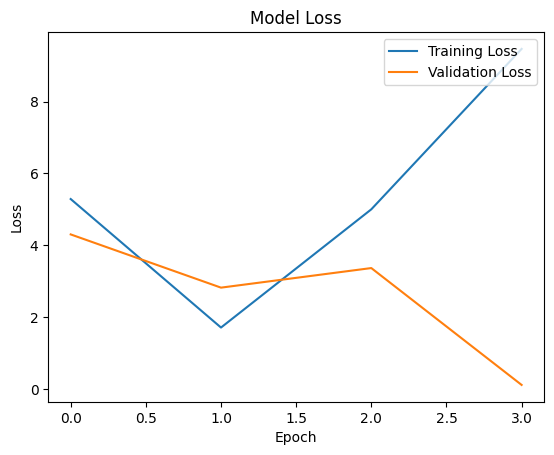

In [7]:
history = model.fit(training_set,  # Repeat the dataset
                    validation_data=test_set,  # Repeat the dataset
                    epochs=4,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()



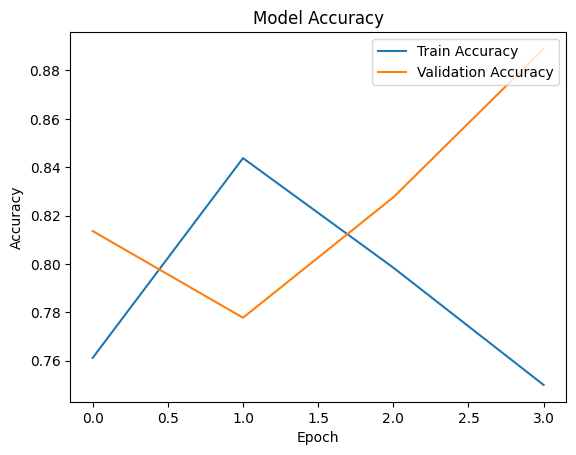

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

## F1 score

In [9]:
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.utils.multiclass import type_of_target
f1_scores = []
val_f1_scores = []
for epoch in range(len(history.history['loss'])):
    # Predict on prediction set
    y_true_Predset = []
    y_pred_Predset = []
    for i in range(len(pred_set)):
        x_batch, y_batch = pred_set[i]
        y_true_Predset.append(y_batch)
        y_pred_Predset.append((model.predict(x_batch) > 0.5).astype("int32"))
    y_true_Predset = np.concatenate(y_true_Predset, axis=0)
    y_pred_Predset = np.concatenate(y_pred_Predset, axis=0)
    f1_train = f1_score(y_true_Predset, y_pred_Predset, average='weighted')
    f1_scores.append(f1_train)



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

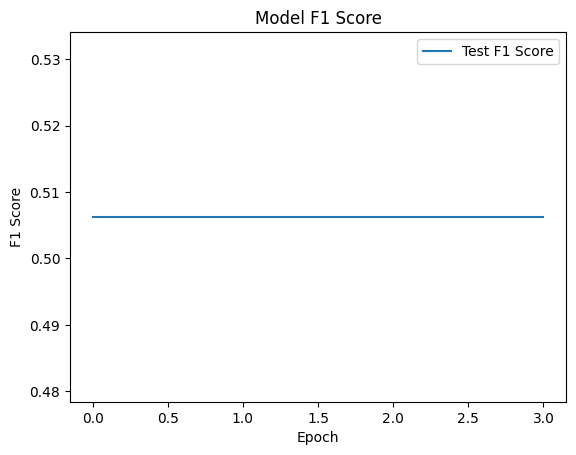

In [10]:
import matplotlib.pyplot as plt

plt.plot(f1_scores, label='Test F1 Score')

plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 587ms/step


<Figure size 1000x800 with 0 Axes>

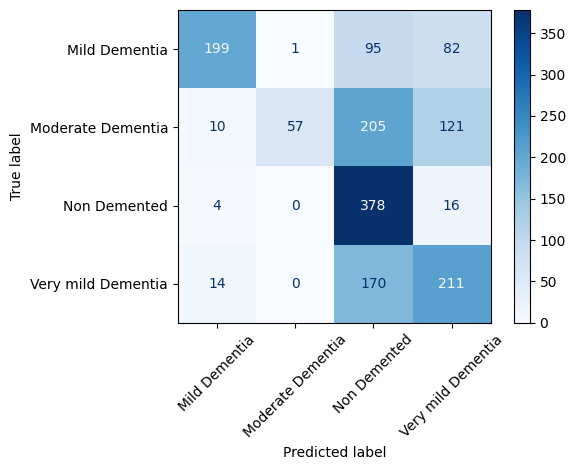

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model
# Predicting the classes for the pred_set
predictions = model.predict(pred_set)
predicted_classes = np.argmax(predictions, axis=1)

# Getting the true classes from the pred_set
true_classes = pred_set.classes

# Creating the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Adjust figure size to avoid overlap
plt.figure(figsize=(10, 8))

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_set.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # Rotate x-axis labels

# Adjust layout to prevent text overlap
plt.tight_layout()

plt.show()


## Roc And AUC curve

49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step


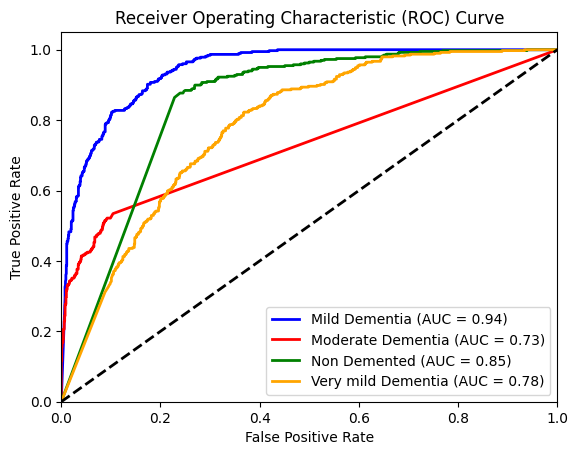

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model
# Predicting the probabilities for the pred_set
y_pred = model.predict(pred_set)
y_true = pred_set.classes
y_true = np.eye(4)[y_true]  # One-hot encoding for true classes

# Define class names
class_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

# Plot ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Classification report

In [15]:
from sklearn.metrics import classification_report

# Assuming y_true are the true labels and y_pred are the predicted probabilities
y_true = pred_set.classes
y_pred = model.predict(pred_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'] # Replace with your actual class names
report = classification_report(y_true, y_pred_classes, target_names=target_names)

print(report)

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.88      0.53      0.66       377
 Moderate Dementia       0.98      0.15      0.25       393
      Non Demented       0.45      0.95      0.61       398
Very mild Dementia       0.49      0.53      0.51       395

          accuracy                           0.54      1563
         macro avg       0.70      0.54      0.51      1563
      weighted avg       0.70      0.54      0.51      1563

